# Variational Autoencoders

<img src="VAE.JPG">

## Download MNIST and load it

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import shutil
from keras.datasets import mnist


def img_tile(imgs, aspect_ratio=1.0, tile_shape=None, border=1,
             border_color=0):
    imgs = np.array(imgs)
    if imgs.ndim != 3 and imgs.ndim != 4:
        raise ValueError('imgs has wrong number of dimensions.')
    n_imgs = imgs.shape[0]

    # Grid shape
    img_shape = np.array(imgs.shape[1:3])
    if tile_shape is None:
        img_aspect_ratio = img_shape[1] / float(img_shape[0])
        aspect_ratio *= img_aspect_ratio
        tile_height = int(np.ceil(np.sqrt(n_imgs * aspect_ratio)))
        tile_width = int(np.ceil(np.sqrt(n_imgs / aspect_ratio)))
        grid_shape = np.array((tile_height, tile_width))
    else:
        assert len(tile_shape) == 2
        grid_shape = np.array(tile_shape)

    # Tile image shape
    tile_img_shape = np.array(imgs.shape[1:])
    tile_img_shape[:2] = (img_shape[:2] + border) * grid_shape[:2] - border

    # Assemble tile image
    tile_img = np.empty(tile_img_shape)
    tile_img[:] = border_color
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            img_idx = j + i * grid_shape[1]
            if img_idx >= n_imgs:
                # No more images - stop filling out the grid.
                break
            img = imgs[img_idx]
            yoff = (img_shape[0] + border) * i
            xoff = (img_shape[1] + border) * j
            tile_img[yoff:yoff + img_shape[0], xoff:xoff + img_shape[1], ...] = img

    return tile_img


def plot_network_output(data, reconst_data, generated, step):
    num = 8
    
    fig, ax = plt.subplots(nrows=3, ncols=num, figsize=(18, 6))
    for i in range(num):
        ax[(0, i)].imshow(np.squeeze(generated[i]), cmap=plt.cm.gray)
        ax[(1, i)].imshow(np.squeeze(data[i]), cmap=plt.cm.gray)
        ax[(2, i)].imshow(np.squeeze(reconst_data[i]), cmap=plt.cm.gray)
        ax[(0, i)].axis('off')
        ax[(1, i)].axis('off')
        ax[(2, i)].axis('off')

    fig.suptitle('Top: generated | Middle: data | Bottom: recunstructed')
#     plt.show()
    plt.savefig(IMAGE_DIR + '/{}.png'.format(str(step).zfill(6)))
    plt.close()
    
    
(train_data, train_label), (test_data, test_label) = mnist.load_data()
train_data = train_data / 255.
test_data = test_data / 255.

Using TensorFlow backend.


## show MNIST

In [2]:
# size of MNIST
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


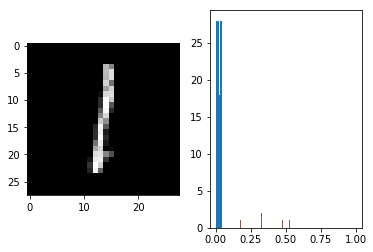

In [3]:
# show data
idx = np.random.randint(0, train_data.shape[0])
_, (ax1, ax2) = plt.subplots(1, 2)
sample_data = train_data[idx]
ax1.imshow(sample_data, 'gray');
ax2.hist(sample_data, bins=20, range=[0, 1]);

## Delete summary folder and make it

In [4]:
SUMMARY_DIR = './vae_summary'
TRAIN_DIR = SUMMARY_DIR + '/train'
TEST_DIR = SUMMARY_DIR + '/test'
IMAGE_DIR = SUMMARY_DIR + '/image'

if os.path.exists(SUMMARY_DIR):
    shutil.rmtree(SUMMARY_DIR)
if not os.path.exists(SUMMARY_DIR):
    os.makedirs(SUMMARY_DIR)
    os.makedirs(TRAIN_DIR)
    os.makedirs(TEST_DIR)
    os.makedirs(IMAGE_DIR)

## Define tensorflow graph

In [5]:
def fully_connected(inputs, out_channel, name='fc'):
    """
    very simple fully connected layer function

    Args:
        inputs: a batch of input tensor [batch_size, n]
                where n is the number of feature dimension
        out_channel: output channel dimension

    Returns:
        inputs * weights + biases [batch_size, out_channel]
    """
    # in_channel: input channel dimension
    # w_shape: shape of weight matrix
    # b_shape: shape of bias vector
    in_channel = inputs.get_shape().as_list()[1]
    w_shape = [in_channel, out_channel]
    b_shape = [out_channel]

    # Define weight matrix variable, bias vector variable
    with tf.variable_scope(name):
        # To share the variables you have to use
        # a function 'tf.get_variable' instead of 'tf.Variable'
        weights = tf.get_variable('weights', shape=w_shape,
                                  initializer=tf.truncated_normal_initializer(stddev=0.02))
        biases = tf.get_variable('biases', shape=b_shape,
                                 initializer=tf.constant_initializer(0.0))

        fc = tf.matmul(inputs, weights)
        fc = tf.nn.bias_add(fc, biases)

        return fc


def encoder(x, z_dim):
    """
    build the encoder

    Args:
        x: a batch of input to the network [batch_size, 28, 28, 1]
        z_dim: dimension of the latent variable z

    returns:
        z_mean: mean of the latent variable [batch_size, n_latent]
        z_log_sigma_sq : log sigma squre of the latent variable [batch_size, n_latent]
    """
    with tf.variable_scope('encoder') as scope:
        
        # Vectorize the input x
        # Fully connected layer with 256 output units and 'fc1' as its name
        # Apply non-linearity function 'relu'
        # Fully connected layer with 256 output units and 'fc2' as its name
        # Apply non-linearity function 'relu'
        # Fully connected layer with z_dim * 2 units and 'fc3' as its name
        # split the final tensor into mean and the log sigma square of the latent variable
        # Return the final tensors
        
        # x : (batch_size, 28,28,1) -> (batch_size, n)
        net = tf.reshape(x, [x.get_shape().as_list()[0], -1]) #(batch_size, n)
        
        net = fully_connected(net, 256, name='fc1')
        net = tf.nn.relu(net) # (batch_size, 256)
        
        net = fully_connected(net, 256, name='fc2')
        net = tf.nn.relu(net)
        
#         z_mean = fully_connected(net, z_dim, name='fc1_mean')
#         z_log_sigma_sq = fully_connected(net, z_dim, name='fc1_squre')
        
        net = fully_connected(net, z_dim * 2, name='fc3') # (batch_size, 2*z_dim)
        
        z_mean, z_log_sigma_sq = tf.split(net, num_or_size_splits=2, axis=1)
        # (batch_size, z_dim), (batch_size, z_dim)
        
        
        
        
        
        return z_mean, z_log_sigma_sq


def decoder(z, reuse=False):
    """
    build the decoder

    Args:
        z: a batch of input to the network [batch_size, n_latent]

    Returns:
        net: output of the generator [batch_size, 28, 28, 1]
    """
    with tf.variable_scope('generator') as scope:
        if reuse:
            scope.reuse_variables()

        # Fully connected layer with 256 output units and 'fc1' as its name
        # Apply non-linearity function 'relu'
        # Fully connected layer with 256 output units and 'fc2' as its name
        # Apply non-linearity function 'relu'
        # Fully connected layer with 784 output units and 'fc3' as its name
        # Apply non-linearity function 'sigmoid'
        # Reshape final output to be a proper image file [28, 28, 1]
        # Return the final tensor
        
        
        net = fully_connected(z, 256, name='fc1')
        net = tf.nn.relu(net) # (batch_size, 256)
        
        net = fully_connected(net, 256, name='fc2')
        net = tf.nn.relu(net)
        
        net = fully_connected(net, 784, name='fc3')
        net = tf.nn.sigmoid(net)
        
        net = tf.reshape(net, [z.get_shape().as_list()[0], 28,28,1])
        
        return net

### reconstrunction_loss = $$-\Sigma_{i=1}^{D} x_{i}log y_{i} + (1-x_{i})log(1-y_{i}))$$
### KL_loss = $$-\frac{1}{2}\Sigma_{j=1}^{J}(1+log \sigma_{j}^2 - \mu_{j}^2 -\sigma_{j}^2)$$
    
### Loss = reconstruction_loss + KL_loss

In [6]:
def get_loss(x, reconst_x, z_mean, z_log_sigma_sq, eps=1e-8):
    """
    get loss of GAN

    Args:
        x: input tensor [batch_size, 28, 28, 1]
        reconst_x: reconstructed tensor [batch_size, 28, 28, 1]
        z_mean: mean of the latent variable [batch_size, z_dim]
        z_log_sigma_sq: log sigma square of the latent variable [batch_size, z_dim]

    Returns:
        reconst_loss: reconstruction loss
        kl_loss: regularization loss
    """
    
    t = x * tf.log(reconst_x + eps) + (1.0 - x) * tf.log(1.0 - reconst_x + eps)
    reconst_loss = -tf.reduce_mean(tf.reduce_sum(t,[1,2,3]))
    
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq), 1))
    
    return reconst_loss, kl_loss


def get_next_batch(data, label, batch_size):
    """
    get 'batch_size' amount of data and label randomly

    Args:
        data: data
        label: label
        batch_size: # of data to get

    Returns:
        batch_data: data of 'batch_size'
        batch_label: coresponding label of batch_data
    """
    n_data = data.shape[0]
    random_idx = random.sample(range(1, n_data), batch_size)

    batch_data = data[random_idx]
    batch_label = label[random_idx]
    return batch_data, batch_label

In [7]:
# Set hyperparameters
batch_size = 100
z_dim = 2
max_step = 20000
lr = 0.001
beta1 = 0.9

# expand the data to be 3 dimensional data.
train_data = np.expand_dims(train_data, 3)
test_data = np.expand_dims(test_data, 3)

############################# Build the model #############################
# Define image tensor x placeholder
x = tf.placeholder(tf.float32, [batch_size, 28, 28, 1], name='input_x')
# Define latent tensor z placeholder
z = tf.placeholder(tf.float32, [batch_size, z_dim], name='input_z')



# Build encoder
z_mean, z_log_sigma_sq = encoder(x, z_dim)

# Defin normal distribution (mu=0, sigma=1)
normal_dist = tf.contrib.distributions.Normal(loc=0., scale=1.)
eps = normal_dist.sample([batch_size, z_dim])

# Get epsilon to recover encoded_z

# Get encoded_z using z_mean, z_log_sigma_sq, eps
encoded_z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))


# Build decoder with encoded_z which outputs reconst_x
# reconst_x is reconstruction of the input data x
reconst_x = decoder(encoded_z, False)


# Build decoder with placeholder z which outputs sample_x
# sample_x is generated data from VAE
sample_x = decoder(z, True)
# Get reconst_loss and kl_loss
reconst_loss, kl_loss = get_loss(x, reconst_x, z_mean, z_log_sigma_sq)
loss = reconst_loss + kl_loss

# Make optimization op
opt = tf.train.AdamOptimizer(lr, beta1=beta1)

# Make train op for each network
train = opt.minimize(loss)

# Make initialization op
init = tf.global_variables_initializer()

# Add summary and make op to add summary data to event log
tf.summary.scalar('KL_loss', kl_loss)
tf.summary.scalar('Reconstruction_loss', reconst_loss)
tf.summary.scalar('Total_loss', kl_loss + reconst_loss)
merged = tf.summary.merge_all()

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use tf.cast instead.


## Train VAE

Training data


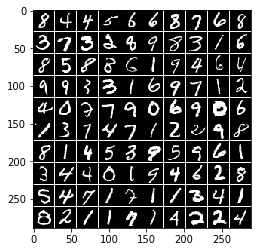

0 steps |  total_loss: 543.4219, KL_loss: 0.0001, reconst_loss: 543.4219


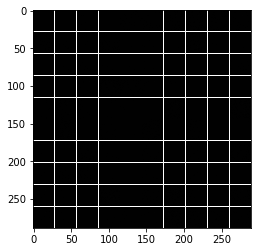

200 steps |  total_loss: 197.5147, KL_loss: 1.8725, reconst_loss: 195.6422


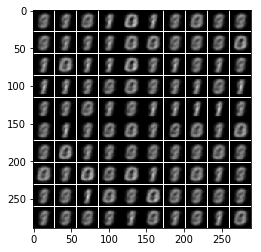

400 steps |  total_loss: 184.0495, KL_loss: 2.3883, reconst_loss: 181.6612


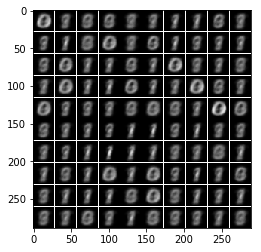

600 steps |  total_loss: 183.3506, KL_loss: 4.3379, reconst_loss: 179.0127


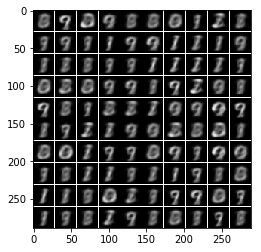

800 steps |  total_loss: 184.3761, KL_loss: 4.3169, reconst_loss: 180.0591


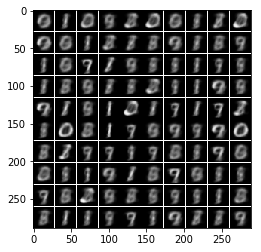

1000 steps |  total_loss: 169.0035, KL_loss: 4.9246, reconst_loss: 164.0789


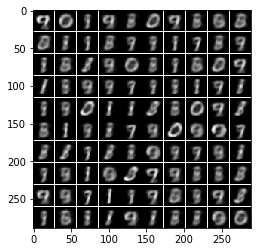

1200 steps |  total_loss: 164.7832, KL_loss: 4.8581, reconst_loss: 159.9250


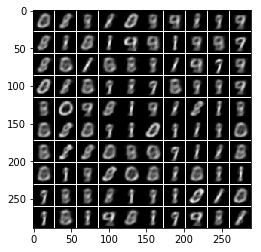

1400 steps |  total_loss: 160.0664, KL_loss: 4.7081, reconst_loss: 155.3582


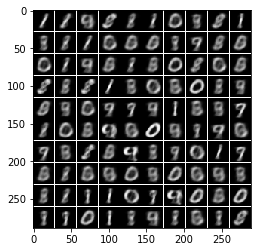

1600 steps |  total_loss: 153.0585, KL_loss: 5.1049, reconst_loss: 147.9536


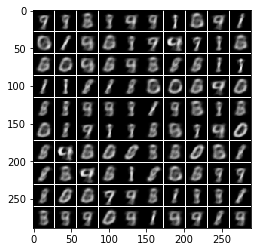

1800 steps |  total_loss: 165.9428, KL_loss: 5.0884, reconst_loss: 160.8544


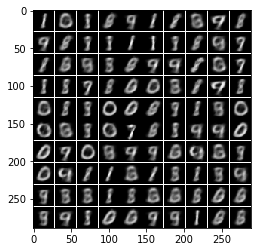

2000 steps |  total_loss: 163.5403, KL_loss: 4.9026, reconst_loss: 158.6377


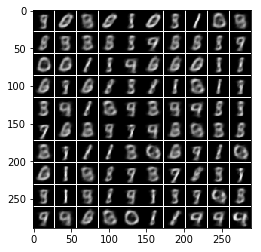

2200 steps |  total_loss: 157.3432, KL_loss: 5.2091, reconst_loss: 152.1341


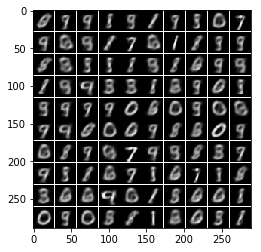

2400 steps |  total_loss: 161.6483, KL_loss: 5.0832, reconst_loss: 156.5651


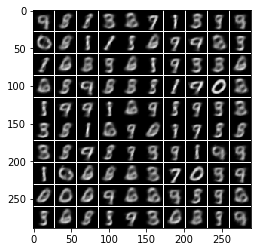

2600 steps |  total_loss: 153.3403, KL_loss: 4.9870, reconst_loss: 148.3532


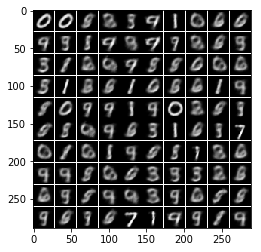

2800 steps |  total_loss: 158.7148, KL_loss: 5.2697, reconst_loss: 153.4450


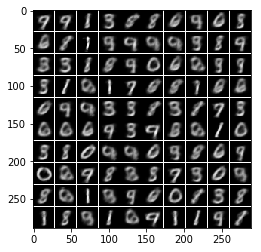

3000 steps |  total_loss: 156.2676, KL_loss: 5.4301, reconst_loss: 150.8375


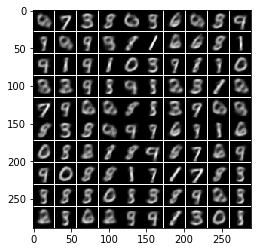

3200 steps |  total_loss: 157.9763, KL_loss: 5.6585, reconst_loss: 152.3178


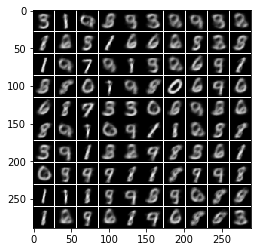

3400 steps |  total_loss: 145.4302, KL_loss: 5.7769, reconst_loss: 139.6533


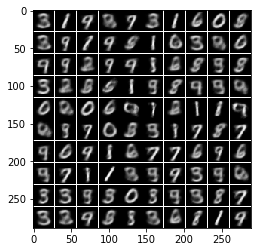

3600 steps |  total_loss: 157.8847, KL_loss: 5.6836, reconst_loss: 152.2011


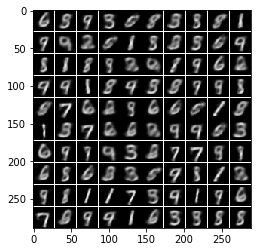

3800 steps |  total_loss: 151.2070, KL_loss: 5.9029, reconst_loss: 145.3041


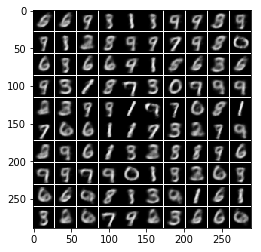

4000 steps |  total_loss: 155.7014, KL_loss: 5.6969, reconst_loss: 150.0044


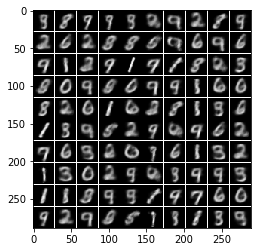

4200 steps |  total_loss: 154.3547, KL_loss: 5.8586, reconst_loss: 148.4960


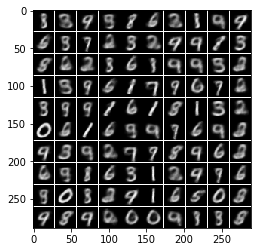

4400 steps |  total_loss: 152.1132, KL_loss: 5.8555, reconst_loss: 146.2577


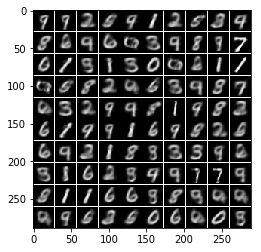

4600 steps |  total_loss: 152.1724, KL_loss: 5.9490, reconst_loss: 146.2234


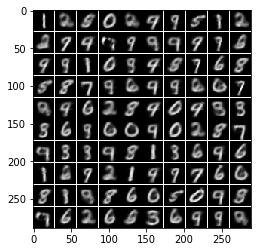

4800 steps |  total_loss: 150.6828, KL_loss: 5.9529, reconst_loss: 144.7299


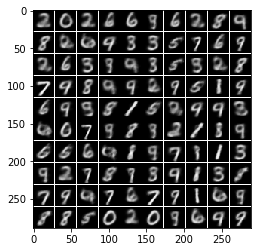

5000 steps |  total_loss: 146.5565, KL_loss: 5.9100, reconst_loss: 140.6465


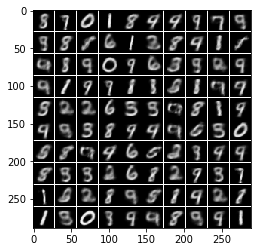

5200 steps |  total_loss: 148.1394, KL_loss: 6.1466, reconst_loss: 141.9928


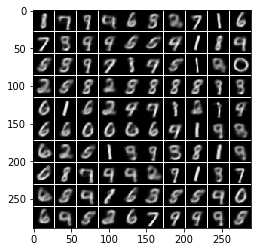

5400 steps |  total_loss: 145.4405, KL_loss: 6.1857, reconst_loss: 139.2548


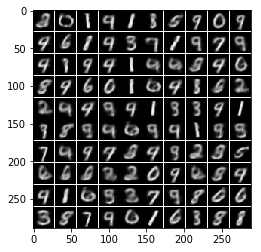

5600 steps |  total_loss: 150.4142, KL_loss: 6.0661, reconst_loss: 144.3481


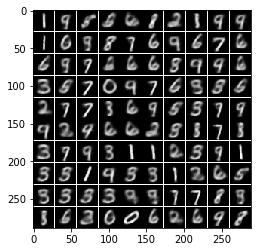

5800 steps |  total_loss: 152.4179, KL_loss: 6.0457, reconst_loss: 146.3722


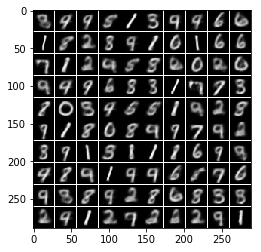

6000 steps |  total_loss: 140.0553, KL_loss: 6.2443, reconst_loss: 133.8110


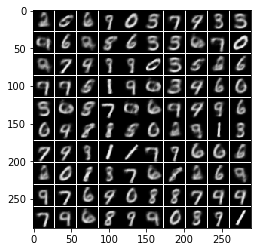

6200 steps |  total_loss: 141.9975, KL_loss: 5.7824, reconst_loss: 136.2151


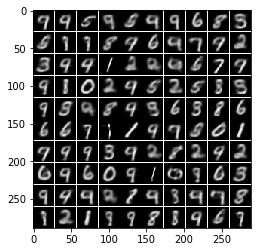

6400 steps |  total_loss: 143.6000, KL_loss: 6.1445, reconst_loss: 137.4556


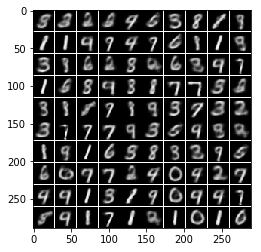

6600 steps |  total_loss: 152.6515, KL_loss: 6.0289, reconst_loss: 146.6226


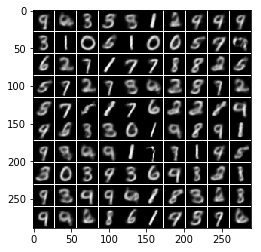

6800 steps |  total_loss: 143.8913, KL_loss: 6.3281, reconst_loss: 137.5632


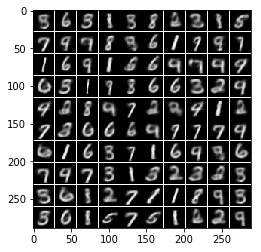

7000 steps |  total_loss: 137.6654, KL_loss: 6.0377, reconst_loss: 131.6277


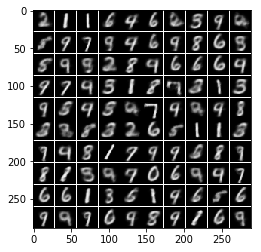

7200 steps |  total_loss: 147.7546, KL_loss: 5.9397, reconst_loss: 141.8148


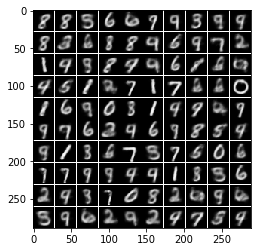

7400 steps |  total_loss: 141.8948, KL_loss: 6.1584, reconst_loss: 135.7363


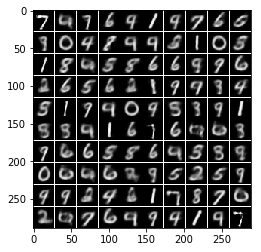

7600 steps |  total_loss: 143.6498, KL_loss: 6.2264, reconst_loss: 137.4234


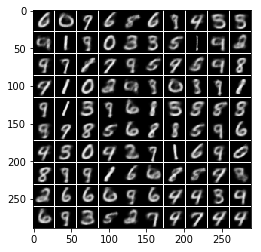

7800 steps |  total_loss: 139.6142, KL_loss: 6.2106, reconst_loss: 133.4036


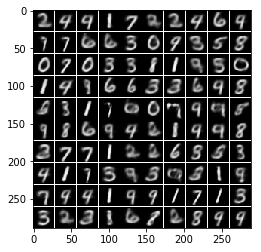

8000 steps |  total_loss: 142.7815, KL_loss: 6.2842, reconst_loss: 136.4972


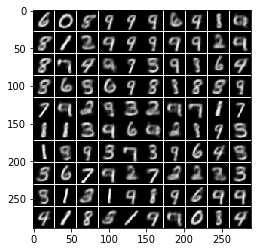

8200 steps |  total_loss: 144.1705, KL_loss: 6.1746, reconst_loss: 137.9959


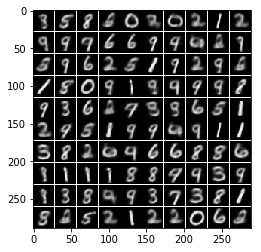

8400 steps |  total_loss: 142.4323, KL_loss: 6.3494, reconst_loss: 136.0828


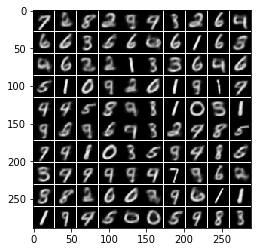

8600 steps |  total_loss: 148.1985, KL_loss: 6.0431, reconst_loss: 142.1555


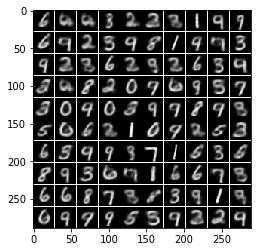

8800 steps |  total_loss: 140.6674, KL_loss: 6.5270, reconst_loss: 134.1404


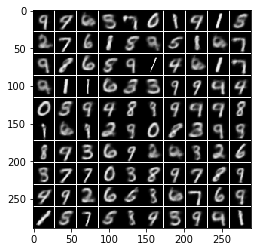

9000 steps |  total_loss: 148.7635, KL_loss: 6.2312, reconst_loss: 142.5322


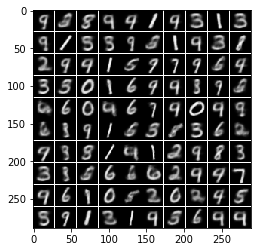

9200 steps |  total_loss: 139.8299, KL_loss: 6.4160, reconst_loss: 133.4139


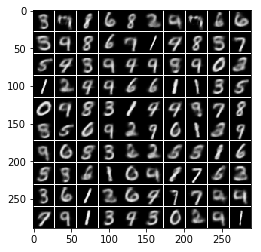

9400 steps |  total_loss: 153.9429, KL_loss: 6.3727, reconst_loss: 147.5701


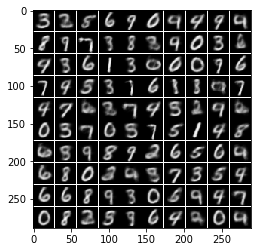

9600 steps |  total_loss: 143.8468, KL_loss: 6.4905, reconst_loss: 137.3562


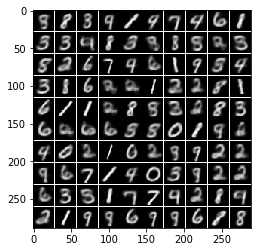

9800 steps |  total_loss: 146.6529, KL_loss: 6.2786, reconst_loss: 140.3742


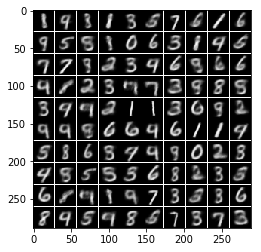

10000 steps |  total_loss: 148.0050, KL_loss: 6.3789, reconst_loss: 141.6261


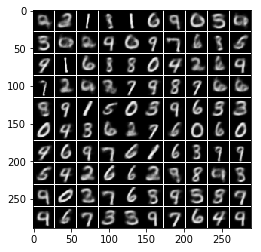

10200 steps |  total_loss: 154.7584, KL_loss: 6.2626, reconst_loss: 148.4958


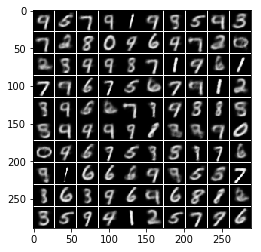

10400 steps |  total_loss: 140.1201, KL_loss: 6.4146, reconst_loss: 133.7055


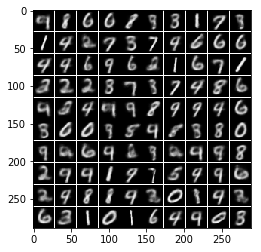

10600 steps |  total_loss: 146.4032, KL_loss: 6.4932, reconst_loss: 139.9100


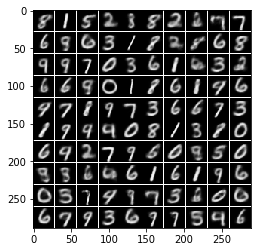

10800 steps |  total_loss: 145.1670, KL_loss: 6.3681, reconst_loss: 138.7990


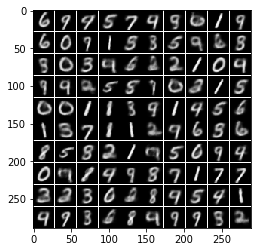

11000 steps |  total_loss: 138.4441, KL_loss: 6.6845, reconst_loss: 131.7596


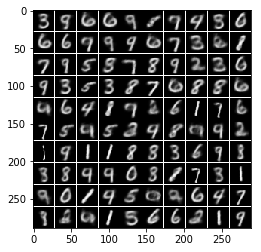

11200 steps |  total_loss: 138.1796, KL_loss: 6.3355, reconst_loss: 131.8441


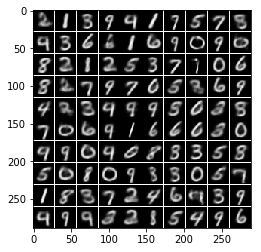

11400 steps |  total_loss: 134.4604, KL_loss: 6.3825, reconst_loss: 128.0779


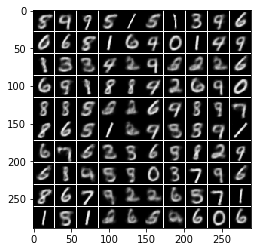

11600 steps |  total_loss: 141.1443, KL_loss: 6.4668, reconst_loss: 134.6775


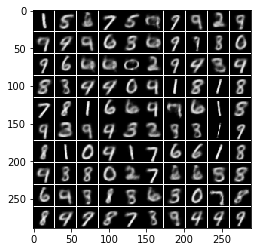

11800 steps |  total_loss: 153.2148, KL_loss: 6.2391, reconst_loss: 146.9756


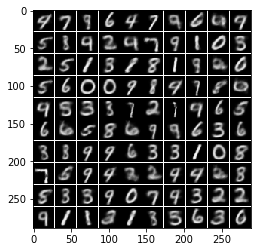

12000 steps |  total_loss: 146.1872, KL_loss: 6.4844, reconst_loss: 139.7027


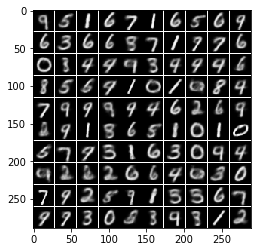

12200 steps |  total_loss: 141.5949, KL_loss: 6.5684, reconst_loss: 135.0266


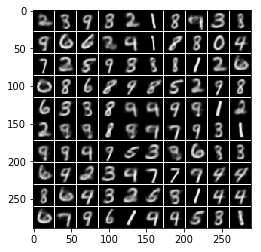

12400 steps |  total_loss: 150.9293, KL_loss: 6.2516, reconst_loss: 144.6777


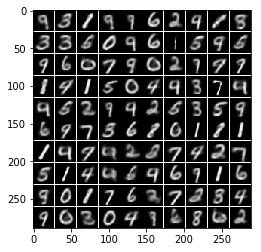

12600 steps |  total_loss: 145.1333, KL_loss: 6.3975, reconst_loss: 138.7358


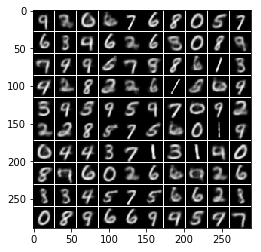

12800 steps |  total_loss: 141.9135, KL_loss: 6.4492, reconst_loss: 135.4644


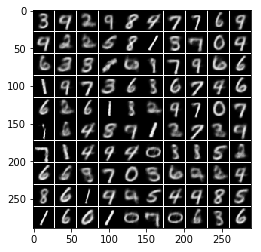

13000 steps |  total_loss: 147.8681, KL_loss: 6.5019, reconst_loss: 141.3661


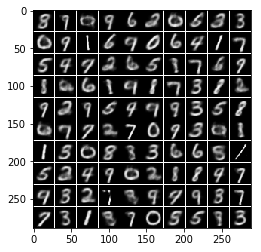

13200 steps |  total_loss: 141.2416, KL_loss: 6.3119, reconst_loss: 134.9297


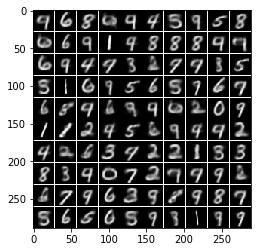

13400 steps |  total_loss: 151.2317, KL_loss: 6.3645, reconst_loss: 144.8672


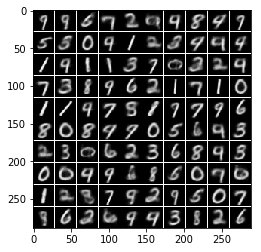

13600 steps |  total_loss: 139.6602, KL_loss: 6.4707, reconst_loss: 133.1895


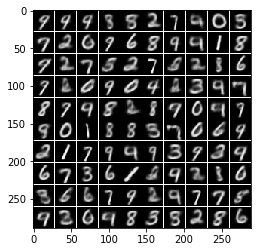

13800 steps |  total_loss: 144.9332, KL_loss: 6.5318, reconst_loss: 138.4014


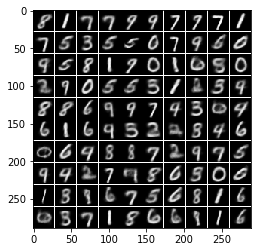

14000 steps |  total_loss: 137.2262, KL_loss: 6.4741, reconst_loss: 130.7521


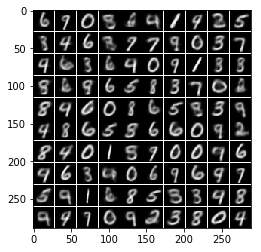

14200 steps |  total_loss: 145.8985, KL_loss: 6.5106, reconst_loss: 139.3879


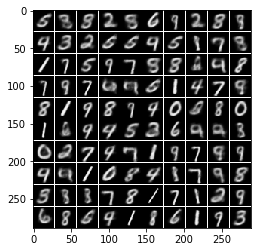

14400 steps |  total_loss: 142.9373, KL_loss: 6.2785, reconst_loss: 136.6588


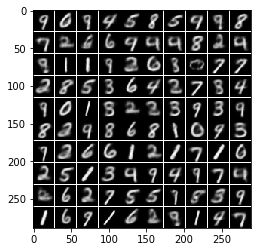

14600 steps |  total_loss: 140.2318, KL_loss: 6.4080, reconst_loss: 133.8238


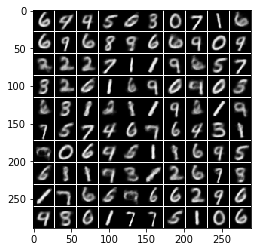

14800 steps |  total_loss: 141.7183, KL_loss: 6.4683, reconst_loss: 135.2500


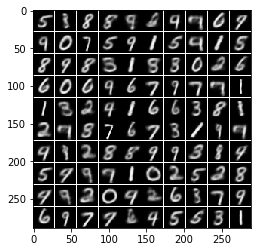

15000 steps |  total_loss: 140.7781, KL_loss: 6.6136, reconst_loss: 134.1644


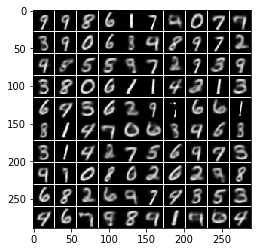

15200 steps |  total_loss: 139.0677, KL_loss: 6.4612, reconst_loss: 132.6065


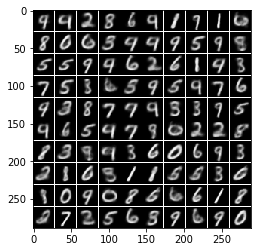

15400 steps |  total_loss: 147.9790, KL_loss: 6.5995, reconst_loss: 141.3794


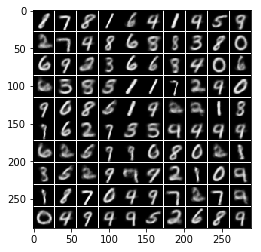

15600 steps |  total_loss: 146.7791, KL_loss: 6.5042, reconst_loss: 140.2749


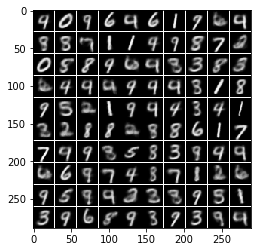

15800 steps |  total_loss: 140.5097, KL_loss: 6.5798, reconst_loss: 133.9299


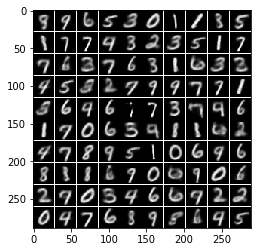

16000 steps |  total_loss: 144.5864, KL_loss: 6.4553, reconst_loss: 138.1311


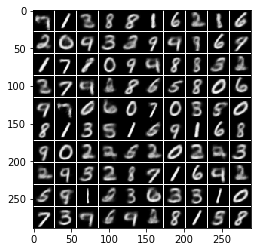

16200 steps |  total_loss: 137.0832, KL_loss: 6.6262, reconst_loss: 130.4570


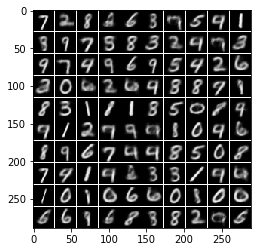

16400 steps |  total_loss: 141.0488, KL_loss: 6.6403, reconst_loss: 134.4085


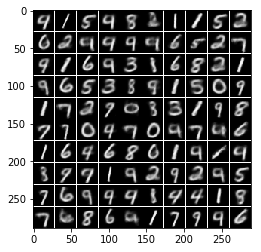

16600 steps |  total_loss: 137.2930, KL_loss: 6.4769, reconst_loss: 130.8162


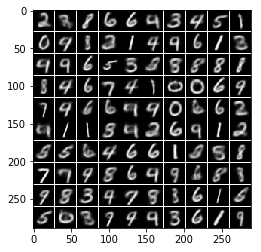

16800 steps |  total_loss: 141.1809, KL_loss: 6.5395, reconst_loss: 134.6413


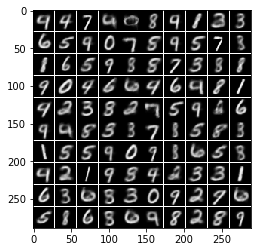

17000 steps |  total_loss: 145.3397, KL_loss: 6.5497, reconst_loss: 138.7900


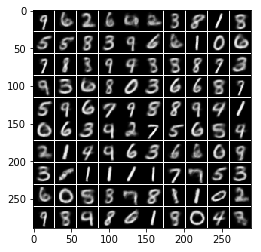

17200 steps |  total_loss: 140.3869, KL_loss: 6.5154, reconst_loss: 133.8716


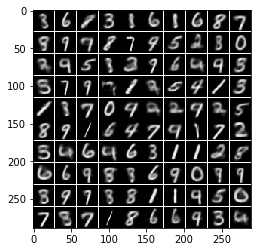

17400 steps |  total_loss: 143.3546, KL_loss: 6.5566, reconst_loss: 136.7980


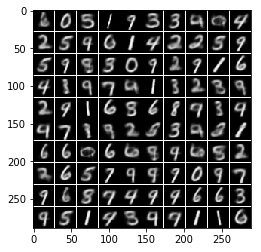

17600 steps |  total_loss: 140.9452, KL_loss: 6.7207, reconst_loss: 134.2245


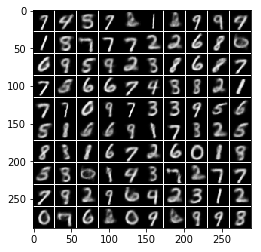

17800 steps |  total_loss: 132.3297, KL_loss: 6.8416, reconst_loss: 125.4881


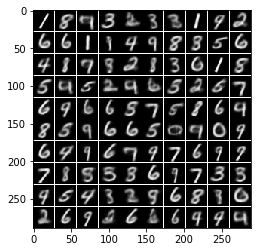

18000 steps |  total_loss: 139.2407, KL_loss: 6.4771, reconst_loss: 132.7636


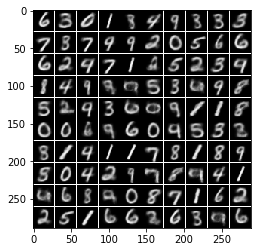

18200 steps |  total_loss: 144.4241, KL_loss: 6.6355, reconst_loss: 137.7885


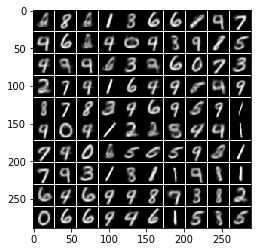

18400 steps |  total_loss: 134.3142, KL_loss: 6.7634, reconst_loss: 127.5508


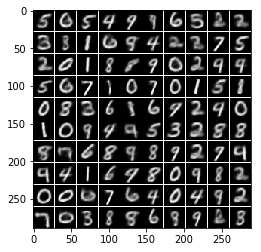

18600 steps |  total_loss: 143.1038, KL_loss: 6.7227, reconst_loss: 136.3811


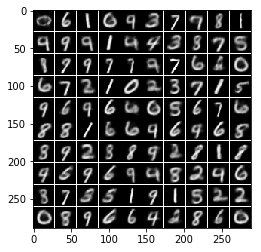

18800 steps |  total_loss: 147.3755, KL_loss: 6.6796, reconst_loss: 140.6960


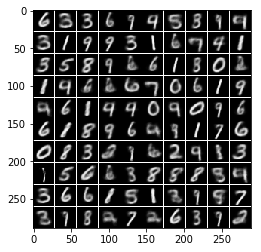

19000 steps |  total_loss: 141.0925, KL_loss: 6.8298, reconst_loss: 134.2628


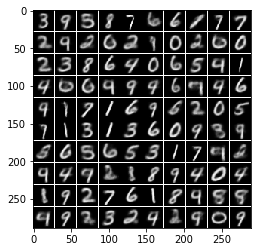

19200 steps |  total_loss: 143.3504, KL_loss: 6.5639, reconst_loss: 136.7865


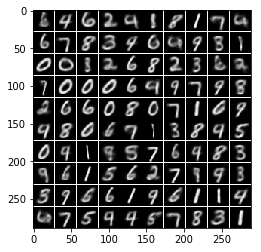

19400 steps |  total_loss: 130.6425, KL_loss: 6.3815, reconst_loss: 124.2610


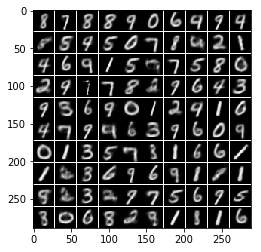

19600 steps |  total_loss: 132.2978, KL_loss: 6.6102, reconst_loss: 125.6877


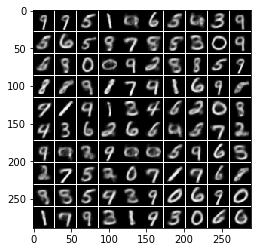

19800 steps |  total_loss: 144.4560, KL_loss: 6.4147, reconst_loss: 138.0413


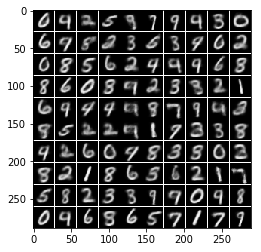

In [8]:
with tf.Session() as sess:
    # Define writer
    train_writer = tf.summary.FileWriter(TRAIN_DIR, sess.graph)
    test_writer = tf.summary.FileWriter(TEST_DIR)
    
    # Initialize variables
    sess.run(init)
    
    # Before train the model, shows train data and save it
    batch_x, batch_y = get_next_batch(train_data, train_label, batch_size)
    train_tiled = img_tile(batch_x, border_color=1.0)
    train_tiled = np.squeeze(train_tiled)
    print("Training data")
    plt.imshow(train_tiled, cmap=plt.cm.gray)
    plt.show()
    plt.imsave(IMAGE_DIR + '/train.png', train_tiled, cmap=plt.cm.gray)

    samples = []
    canvases = []
    # Train the model
    for step in range(max_step):
        batch_x, batch_y = get_next_batch(train_data, train_label, batch_size)
        batch_z = np.random.normal(loc=0., scale=1.0, size=[batch_size, z_dim])
        
        _, reconst_losses, kl_losses = sess.run(
            [train, reconst_loss, kl_loss], feed_dict={x: batch_x, z: batch_z})
        summary = sess.run(merged, feed_dict={x: batch_x, z: batch_z})
        train_writer.add_summary(summary, step)

        # Save generarted data to make gif files
        if step % 50 == 0:
            r_x, s_x = sess.run([reconst_x, sample_x], feed_dict={x: batch_x, z: batch_z})
            sample_tiled = img_tile(s_x, border_color=1.0)
            sample_tiled = np.squeeze(sample_tiled)
            samples.append(sample_tiled)
            
            nx = ny = 20
            x_values = np.linspace(-3, 3, nx)
            y_values = np.linspace(-3, 3, ny)
            canvas = np.empty((28*ny, 28*nx))
            for i, yi in enumerate(x_values):
                for j, xi in enumerate(y_values):
                    z_mu = np.array([[xi, yi]] * batch_size)
                    x_mean = sess.run(sample_x, feed_dict={z: z_mu})
                    canvas[(nx - i - 1) * 28:(nx - i) * 28, j * 28:(j + 1) * 28] = x_mean[0].reshape(28, 28)
            canvases.append(canvas)

        # Log loss and save train data and reconstructed data
        if step % 200 == 0:
            plot_network_output(batch_x, r_x, s_x, step)
            print("{} steps |  total_loss: {:.4f}, KL_loss: {:.4f}, reconst_loss: {:.4f}".format(
                step, kl_losses + reconst_losses, kl_losses, reconst_losses))
            plt.imshow(sample_tiled, cmap=plt.cm.gray)
            plt.show()

In [9]:
import imageio
# Make gif files
imageio.mimsave(SUMMARY_DIR + '/generated.gif', samples)
imageio.mimsave(SUMMARY_DIR + '/canvase.gif', canvases)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0